### 第 1 部分 這邊都是屬於設置類的 Code

In [0]:
#### 清 Ram
!kill -9 -1

In [0]:
#### 連接google drive
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


FileExistsError: ignored

### 第 2 部分 以下執行完會抓出資料，但要注意一下dataset放的路徑

In [0]:
import os
import scipy.io
import cv2
import numpy as np


In [0]:
b = begincwd + '/gdrive'
os.chdir(b)

In [0]:
os.listdir()

['train_label_array.npy',
 'test_label_array.npy',
 'pixel1.txt',
 'pixel3.txt',
 'pixel2.txt',
 'pixel4.txt',
 'answer_pixel1_array.npy',
 'answer_pixel2_array.npy',
 'answer_pixel3_array.npy',
 'answer_pixel4_array.npy',
 'train_pixel1_array.npy',
 'test_pixel1_array.npy',
 'train_pixel2_array.npy',
 'test_pixel2_array.npy',
 'train_pixel3_array.npy',
 'test_pixel3_array.npy',
 'train_pixel4_array.npy',
 'test_pixel4_array.npy',
 'YOLO_final.py',
 'answer_pixel2_array_new.npy',
 'answer_pixel4_array_new.npy',
 'answer_pixel1_array_new.npy',
 'test_pixel0.5_array_new.npy',
 'test_pixel1_array_new.npy',
 'test_pixel1.5_array_new.npy',
 'test_pixel2_array_new.npy']

In [0]:
begincwd = os.getcwd()
b ='/content/gdrive/All code and data for Yolo/egohands_dataset/_LABELLED_SAMPLES'
os.chdir(b)
a = os.listdir()
a.remove('.DS_Store')
a.sort()

all_frame_dic = {}
all_dic = {}
for i in range(len(a)):
    os.chdir(a[i])
    mat = scipy.io.loadmat('polygons.mat')
    img_name = os.listdir()
    img_name.remove('polygons.mat')
    img_name.sort()
    all_frame_dic[i] = img_name
    ls = list(mat['polygons'][0])
    dic = {}
    for j in range(len(ls)):
        need = {'1': ls[j][0], '2': ls[j][1], '3': ls[j][2], '4': ls[j][3]}
        name = j
        dic[name] = need
    all_name = a[i]
    all_dic[all_name] = dic
    os.chdir(b)
os.chdir(begincwd)

In [0]:
def call_data(k, t):
    return all_dic[k][t]


def call_img(k, t):
    b = '/content/gdrive/All code and data for Yolo/egohands_dataset/_LABELLED_SAMPLES/' + k
    os.chdir(b)
    img = cv2.imread(t)
    cv2.imshow(t, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def call_img_pixel(kk, tt):
    bb = '/content/gdrive/All code and data for Yolo/egohands_dataset/_LABELLED_SAMPLES/'+ kk
    os.chdir(bb)
    img = np.float32(cv2.imread(tt))
    return img


In [0]:
all_place = list(all_dic.keys())
all_center = dict()
all_box = dict()
for i in range(len(all_place)):
    all_frame = list(all_dic[all_place[i]].keys())
    dic_box = {}
    dic_center = {}
    for j in range(len(all_frame)):
        sublist = ['1', '2', '3', '4']
        for k in sublist:
            length = len(call_data(all_place[i], all_frame[j])[k])
            if length > 1:
                x_array = call_data(all_place[i], all_frame[j])[k][range(length), 0]
                y_array = call_data(all_place[i], all_frame[j])[k][range(length), 1]
                max_x = max(np.array(x_array))
                max_y = max(np.array(y_array))
                min_x = min(np.array(x_array))
                min_y = min(np.array(y_array))
                nam = 'array' + k
                nam2 = 'arrayb' + k
                globals()[nam] = np.array([(max_x + min_x) / 2, (max_y + min_y) / 2])
                globals()[nam2] = np.array([(max_x - min_x), (max_y - min_y)])
            if length == 1:
                nam = 'array' + k
                nam2 = 'arrayb' + k
                globals()[nam] = np.array([])
                globals()[nam2] = np.array([])
        dic_center[all_frame[j]] = np.array([array1, array2, array3, array4])
        dic_box[all_frame[j]] = np.array([arrayb1, arrayb2, arrayb3, arrayb4])
    all_center[all_place[i]] = dic_center
    all_box[all_place[i]] = dic_box


In [0]:
all_ans = dict()
for i in range(len(all_place)):
    all_frame = list(all_dic[all_place[i]].keys())
    dic_ans = {}
    for j in range(len(all_frame)):
        real_center = all_center[all_place[i]][all_frame[j]]
        real_box = all_box[all_place[i]][all_frame[j]]
        real_ans = np.zeros([5, 18, 32])
        for k in range(4):
            if len(real_center[k]) > 1:
                chan_x = int(real_center[k][0] / 40)
                chan_y = int(real_center[k][1] / 40)
                real_ans[0, chan_y, chan_x] = 1
                real_ans[1, chan_y, chan_x] = real_center[k][0] / 40 - chan_x
                real_ans[2, chan_y, chan_x] = real_center[k][1] / 40 - chan_y
                real_ans[3, chan_y, chan_x] = (real_box[k][0]) / 1280
                real_ans[4, chan_y, chan_x] = (real_box[k][1]) / 720
        dic_ans[all_frame[j]] = real_ans
    all_ans[all_place[i]] = dic_ans


def call_data_ans(k, t):
    return all_ans[k][t]

### 第 3 部分以下開始寫 Label 的答案

In [0]:
train_label_array = np.zeros((60*48, 5, 18, 32))
test_label_array = np.zeros((40*48, 5, 18, 32))
for i in range(len(all_place)):
    for j in range(0, int(len(all_frame_dic[i]) * 0.6)):
        train_label_array[60 * i + j] = call_data_ans(all_place[i], j)
    for k in range(int(len(all_frame_dic[i]) * 0.6), len(all_frame_dic[i])):
        test_label_array[40 * i + k-60] = call_data_ans(all_place[i], k)

In [0]:
os.chdir(begincwd + '/gdrive/All code and data for Yolo')

In [0]:
os.listdir()

['egohands_dataset',
 'Model相關',
 'Label and Pixel',
 'video capture.ipynb',
 'new_yolo.ipynb',
 '製造所有label&pixel.ipynb']

以 Numpy 儲存 Label

In [0]:
train_label_array.shape

(2880, 5, 18, 32)

In [0]:
np.save('train_label_array',train_label_array)

In [0]:
np.save('test_label_array',test_label_array)

In [0]:
type(call_img_pixel(all_place[0],all_frame_dic[0][1]))

numpy.ndarray

### 第 4 部分以下將圖片 Pixel 切成4份分開存成 txt 檔

第 1 份

In [0]:
## 存取
image_list = list()
for i in range(0,12):
    for j in range(len(all_frame_dic[i])):
        img = call_img_pixel(all_place[i],all_frame_dic[i][j])
        image_list.append(img)
        print(i,j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 0
2 1
2 2
2 3
2 4


In [0]:
len(image_list[1][1][1])
#1200,720,1280,3

3

In [0]:
os.chdir('/content/gdrive/All code and data for Yolo')

In [0]:
os.listdir()

['egohands_dataset',
 'answer_numpy.ipynb',
 'answer2.ipynb',
 'train_label_array.npy',
 'test_label_array.npy']

In [0]:
#### 寫入
import pickle
with open("pixel1_new.txt", "wb") as file:   #Pickling
  pickle.dump(image_list, file)

第 2 份

In [0]:
image_list = list()
for i in range(12,24):
    for j in range(len(all_frame_dic[i])):
        img = call_img_pixel(all_place[i],all_frame_dic[i][j])
        image_list.append(img)
        print(i,j)

In [0]:
os.chdir(begincwd + '/gdrive')

In [0]:
os.listdir()

['egohands_dataset',
 'answer_numpy.ipynb',
 'answer2.ipynb',
 'train_label_array.npy',
 'test_label_array.npy',
 'pixel1.txt',
 'pixel3.txt']

In [0]:
import pickle
with open("pixel2.txt", "wb") as file:   #Pickling
  pickle.dump(image_list, file)

第 3 份

In [0]:
image_list = list()
for i in range(24,36):
    for j in range(len(all_frame_dic[i])):
        img = call_img_pixel(all_place[i],all_frame_dic[i][j])
        image_list.append(img)
        print(i,j)

In [0]:
os.chdir(begincwd + '/gdrive')

In [0]:
os.listdir()

['egohands_dataset',
 'answer_numpy.ipynb',
 'answer2.ipynb',
 'train_label_array.npy',
 'test_label_array.npy',
 'pixel1.txt']

In [0]:
import pickle
with open("pixel3.txt", "wb") as file:   #Pickling
  pickle.dump(image_list, file)

第 4 份

In [0]:
image_list = list()
for i in range(36,48):
    for j in range(len(all_frame_dic[i])):
        img = call_img_pixel(all_place[i],all_frame_dic[i][j])
        image_list.append(img)
        print(i,j)

In [0]:
os.chdir(begincwd + '/gdrive')

In [0]:
os.listdir()

['egohands_dataset',
 'answer_numpy.ipynb',
 'answer2.ipynb',
 'train_label_array.npy',
 'test_label_array.npy',
 'pixel1.txt',
 'pixel3.txt',
 'pixel2.txt']

In [0]:
import pickle
with open("pixel4.txt", "wb") as file:   #Pickling
  pickle.dump(image_list, file)

## tensorflow 存 pixel

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


FileExistsError: ignored

In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
with open("pixel1.txt", "rb") as fp:   # Unpickling
  pixel = pickle.load(fp)

### 第 5 部分 將 Txt 存成 Numpy array

第 1 份

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
with open("pixel1.txt", "rb") as fp:   # Unpickling
  pixel = pickle.load(fp)

In [0]:
import tensorflow as tf

pixel2 = tf.convert_to_tensor(pixel)
sess=tf.Session()
print(sess.run(pixel2))

ValueError: ignored

In [0]:
print(pixel)

In [0]:
np.save('answer_pixel1_array_new',answer)

第 2 份

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
with open("pixel2.txt", "rb") as fp:   # Unpickling
  pixel = pickle.load(fp)

In [0]:
answer = np.array(pixel)
answer.shape

(1200, 720, 1280, 3)

In [0]:
np.save('answer_pixel2_array_new',answer)

第 3 份

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
with open("pixel3.txt", "rb") as fp:   # Unpickling
  pixel = pickle.load(fp)

In [0]:
answer = np.array(pixel)
answer.shape

(1200, 720, 1280, 3)

In [0]:
np.save('answer_pixel3_array_new',answer)

第 4 份

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
with open("pixel4.txt", "rb") as fp:   # Unpickling
  pixel = pickle.load(fp)

In [0]:
answer = np.array(pixel)
answer.shape

(1200, 720, 1280, 3)

In [0]:
np.save('answer_pixel4_array_new',answer)

###第 6 部分 將每一份 Numpy 分成 test 跟 train ，並以 Numpy 形式儲存

第 1 份

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
need = np.load('answer_pixel1_array_new.npy')

In [0]:
train_pixel = np.zeros((60*6, 720, 1280, 3))
test_pixel = np.zeros((40*6, 720, 1280, 3))
for i in range(6):
  for j in range(0, 60):  
    train_pixel[60 * i + j] = need[i*100+j]
  for k in range(60, 100):
    test_pixel[40 * i + k-60] = need[i*100+k]

In [0]:
np.save('train_pixel0.5_array_new',train_pixel)

In [0]:
np.save('test_pixel0.5_array_new',test_pixel)

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
os.listdir()

In [0]:
need = np.load('answer_pixel1_array_new.npy')

In [0]:
need.shape

(1200, 720, 1280, 3)

In [0]:
train_pixel = np.zeros((60*6, 720, 1280, 3))
test_pixel = np.zeros((40*6, 720, 1280, 3))
for i in range(6,12):
  for j in range(0, 60):  
    train_pixel[60 * (i-6) + j] = need[(i-6)*100+j]
  for k in range(60, 100):
    test_pixel[40 * (i-6) + k-60] = need[(i-6)*100+k]

In [0]:
np.save('train_pixel1_array_new',train_pixel)

In [0]:
np.save('test_pixel1_array_new',test_pixel)

第 2 份

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
need = np.load('answer_pixel2_array_new.npy')

In [0]:
train_pixel = np.zeros((60*6, 720, 1280, 3))
test_pixel = np.zeros((40*6, 720, 1280, 3))
for i in range(6):
  for j in range(0, 60):  
    train_pixel[60 * i + j] = need[i*100+j]
  for k in range(60, 100):
    test_pixel[40 * i + k-60] = need[i*100+k]

In [0]:
np.save('train_pixel1.5_array_new',train_pixel)

In [0]:
np.save('test_pixel1.5_array_new',test_pixel)

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
need = np.load('answer_pixel2_array_new.npy')

In [0]:
train_pixel = np.zeros((60*6, 720, 1280, 3))
test_pixel = np.zeros((40*6, 720, 1280, 3))
for i in range(6,12):
  for j in range(0, 60):  
    train_pixel[60 * (i-6) + j] = need[(i-6)*100+j]
  for k in range(60, 100):
    test_pixel[40 * (i-6) + k-60] = need[(i-6)*100+k]

In [0]:
np.save('train_pixel2_array_new',train_pixel)

In [0]:
np.save('test_pixel2_array_new',test_pixel)

##第 3 份 還沒做

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive')

In [0]:
need = np.load('answer_pixel3_array.npy')

In [0]:
train = need[0:60]
for i in range(12):
  dummy = need[100*(1+i):100*(1+i)+60]
  train = np.vstack([train,dummy])
    
train.shape

(720, 3, 720, 1280)

In [0]:
test = need[60:100]
for i in range(12):
  dummy = need[100*(1+i)+60:100*(2+i)]
  test = np.vstack([test,dummy])

test.shape

(480, 3, 720, 1280)

In [0]:
np.save('train_pixel3_array',train)

In [0]:
np.save('test_pixel3_array',test)

## 第 4 份 還沒做

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 35748363
-rw------- 1 root root      28219 May 12 15:05 answer2.ipynb
-rw------- 1 root root      31077 May 12 15:21 answer_numpy.ipynb
-rw------- 1 root root 3317760128 May 11 17:56 answer_pixel1_array.npy
-rw------- 1 root root 3317760128 May 11 18:05 answer_pixel2_array.npy
-rw------- 1 root root 3317760128 May 11 18:13 answer_pixel3_array.npy
-rw------- 1 root root 3317760128 May 11 18:21 answer_pixel4_array.npy
drwx------ 2 root root       4096 May 11 16:0

In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive')

In [0]:
need = np.load('answer_pixel4_array.npy')

KeyboardInterrupt: ignored

In [0]:
train = need[0:60]
for i in range(12):
  dummy = need[100*(1+i):100*(1+i)+60]
  train = np.vstack([train,dummy])
    
train.shape

(720, 3, 720, 1280)

In [0]:
test = need[60:100]
for i in range(12):
  dummy = need[100*(1+i)+60:100*(2+i)]
  test = np.vstack([test,dummy])

test.shape

(480, 3, 720, 1280)

In [0]:
np.save('train_pixel4_array',train)

In [0]:
np.save('test_pixel4_array',test)

##第 7 部分 將 train 的 pixel 合併

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

1.  將前兩份合併

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
train1 = np.load('test_pixel0.5_array_new.npy')

In [0]:
os.chdir('/content/gdrive/All code and data for Yolo/egohands_dataset/_LABELLED_SAMPLES/PUZZLE_LIVINGROOM_B_T')

In [0]:
os.listdir()

['frame_1490.jpg',
 'frame_0834.jpg',
 'frame_0439.jpg',
 'frame_1096.jpg',
 'frame_0765.jpg',
 'frame_2358.jpg',
 'frame_1527.jpg',
 'frame_2238.jpg',
 'frame_0189.jpg',
 'frame_1537.jpg',
 'frame_1318.jpg',
 'frame_0006.jpg',
 'frame_0002.jpg',
 'frame_2567.jpg',
 'frame_1279.jpg',
 'frame_0575.jpg',
 'frame_0946.jpg',
 'frame_1333.jpg',
 'frame_1523.jpg',
 'frame_1643.jpg',
 'frame_2161.jpg',
 'frame_1382.jpg',
 'frame_2570.jpg',
 'frame_1291.jpg',
 'frame_0671.jpg',
 'frame_1585.jpg',
 'frame_0048.jpg',
 'frame_1961.jpg',
 'frame_1340.jpg',
 'frame_1430.jpg',
 'frame_1022.jpg',
 'frame_1587.jpg',
 'frame_1009.jpg',
 'frame_2515.jpg',
 'frame_2459.jpg',
 'frame_1800.jpg',
 'frame_0702.jpg',
 'frame_2114.jpg',
 'frame_1025.jpg',
 'frame_1182.jpg',
 'frame_2666.jpg',
 'frame_2329.jpg',
 'frame_1434.jpg',
 'frame_1542.jpg',
 'frame_1150.jpg',
 'frame_0675.jpg',
 'frame_2499.jpg',
 'frame_1230.jpg',
 'frame_2248.jpg',
 'frame_1379.jpg',
 'frame_2664.jpg',
 'frame_1386.jpg',
 'frame_1836

In [0]:
np.asarray(pil_im)

array([[[159, 141,  75],
        [163, 143,  82],
        [168, 146,  96],
        ...,
        [ 81,  60,  99],
        [ 81,  61,  96],
        [ 81,  62,  92]],

       [[163, 143,  82],
        [166, 145,  88],
        [169, 147,  97],
        ...,
        [ 82,  62,  97],
        [ 84,  64, 101],
        [ 84,  64,  99]],

       [[165, 143,  93],
        [167, 145,  96],
        [169, 147,  97],
        ...,
        [ 83,  65,  87],
        [ 85,  66,  98],
        [ 86,  65, 106]],

       ...,

       [[107,  58,  41],
        [109,  58,  37],
        [108,  59,  26],
        ...,
        [ 81, 116, 122],
        [ 82, 118, 108],
        [ 85, 120, 100]],

       [[108,  57,  56],
        [108,  58,  51],
        [108,  57,  36],
        ...,
        [ 82, 116, 126],
        [ 82, 117, 110],
        [ 85, 120, 100]],

       [[107,  55,  59],
        [109,  58,  55],
        [109,  57,  43],
        ...,
        [ 82, 116, 126],
        [ 82, 117, 110],
        [ 84, 119,  99]]

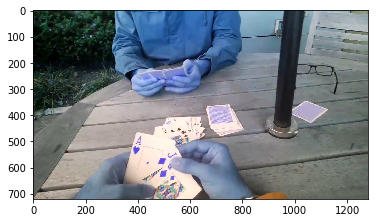

In [0]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open(os.listdir()[0], 'r')
imshow(np.array(train1[40],dtype='uint8'))


array([[[107., 115., 108.],
        [110., 118., 111.],
        [115., 123., 116.],
        ...,
        [175., 232., 247.],
        [167., 222., 253.],
        [163., 221., 255.]],

       [[102., 110., 103.],
        [105., 113., 106.],
        [111., 119., 112.],
        ...,
        [176., 235., 250.],
        [166., 227., 253.],
        [159., 223., 254.]],

       [[ 95., 103.,  96.],
        [ 99., 107., 100.],
        [105., 113., 106.],
        ...,
        [176., 245., 254.],
        [166., 235., 255.],
        [154., 226., 250.]],

       ...,

       [[ 14.,  17.,  15.],
        [ 14.,  17.,  15.],
        [ 14.,  17.,  15.],
        ...,
        [ 68.,  64.,  59.],
        [ 68.,  64.,  59.],
        [ 68.,  64.,  59.]],

       [[ 12.,  15.,  13.],
        [ 12.,  15.,  13.],
        [ 12.,  15.,  13.],
        ...,
        [ 68.,  64.,  59.],
        [ 68.,  64.,  59.],
        [ 68.,  64.,  59.]],

       [[ 11.,  14.,  12.],
        [ 11.,  14.,  12.],
        [ 11.,  

In [0]:
os.chdir('/content/gdrive/All code and data for Yolo/Label and Pixel')

In [0]:
np.save('train_pixel_firsthalf_0.5_array_new', np.vstack([np.load('train_pixel0.5_array_new.npy'),
                   np.load('train_pixel1_array_new.npy')]))

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
train1 = np.vstack([np.load('train_pixel0.5_array_new.npy'),
                   np.load('train_pixel1_array_new.npy')])

In [0]:
np.save('train_pixel_firsthalf_1_array_new',train1)

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 12
drwx------ 2 root root 4096 May 20 16:10 'All code and data for Yolo'
drwx------ 2 root root 4096 Jun 13 08:32  Energy
drwx------ 2 root root 4096 May 20 16:12 '中間產生檔案 or 舊檔'


In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

1.  將前兩份合併

In [0]:
os.chdir('/content/gdrive/中間產生檔案 or 舊檔')

In [0]:
train1 = np.vstack([np.load('train_pixel0.5_array_new.npy'),
                   np.load('train_pixel1_array_new.npy')])

In [0]:
np.save('train_pixel_firsthalf_0.5_array_new',train1)

2 . 將後兩份合併

In [0]:
train1 = np.load('train_pixel3_array.npy')

In [0]:
train2 = np.load('train_pixel4_array.npy')

In [0]:
train = np.vstack([train1,train2])

In [0]:
np.save('train_pixel_secondhalf_array',train)

### 附錄：以下試圖把全部合併在一起  但失敗

In [0]:
!kill -9 -1

In [0]:
import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 46764376
-rw------- 1 root root      28219 May 12 15:05 answer2.ipynb
-rw------- 1 root root      42177 May 12 16:02 answer_numpy.ipynb
-rw------- 1 root root 3317760128 May 11 17:56 answer_pixel1_array.npy
-rw------- 1 root root 3317760128 May 11 18:05 answer_pixel2_array.npy
-rw------- 1 root root 3317760128 May 11 18:13 answer_pixel3_array.npy
-rw------- 1 root root 3317760128 May 11 18:21 answer_pixel4_array.npy
drwx------ 2 root root       4096 May 11 16:0

In [0]:
import os
import scipy.io
import cv2
import numpy as np
import pickle
from google.colab.patches import cv2_imshow

In [0]:
os.chdir('/content/gdrive')

In [0]:
train1=np.load('train_pixel_firsthalf_array.npy')

In [0]:
train2=np.load('train_pixel_secondhalf_array.npy')

In [0]:
np.save('train_pixel_all_array',np.vstack([np.load('train_pixel_firsthalf_array.npy'),np.load('train_pixel_secondhalf_array.npy')]))